In [236]:
import numpy as np
import random as rm

def cat_sampler(Probs):
    if sum(Probs) != 1:
        Probs = Probs/np.sum(Probs)
        
    tmp = rm.random()
    CumProbs = np.cumsum(Probs) - tmp
    tmpInd = np.where(CumProbs>0)
    Ind = tmpInd[0][0]
    return Ind

In [235]:
import numpy as np
import math

def gen_Data(NPix,NPulse,TInterP,Lifetimes,SpecInd,ExcProbs,TauIRF,SigIRF):
   # genData() generates a set of arrival times from input lifetimes 
   # and excitation probability.
   #
   # NPix: number of pixels
   # NPulse: number of pulses per pixel
   # NInterP: interpulse time (ns)
   # Lifetimes: array of species lifetimes (ns)
   # SpecInd: index to assign spectrum from the list to species
   # ExcProbs: species excitation probabilities    
   # TauIRF: mean of the IRF (ns)
   # SigIRF: sigma of the IRF (ns)

   Alphas = np.array([1.4, 55, 420, 150, 200])
   Betas = np.array([30, 10, 1.6, 3.25, 2.9])
   Lambda = np.zeros((NPix,32))
   Dt = {}
   SpecBands = np.array(range(375,760,12))
   NSpec = np.size(Lifetimes)
   for pp in range(0,NPix):
      tmpDt = np.array([])
      print(pp)
      for ii in range(0,NPulse):
         tmp = 1-np.exp(-2*SigIRF*np.sum(ExcProbs[pp,:]))
         if tmp > np.random.rand():
            Ind = cat_sampler(ExcProbs[pp,:])
            ExcTime = np.random.normal(TauIRF,SigIRF) + np.random.exponential(Lifetimes[Ind])
            ArrivTime = ExcTime - TInterP*math.floor(ExcTime/TInterP)
            tmpDt = np.append(tmpDt,ArrivTime)
            if SpecInd[Ind]==0:
               tmpLamd = np.random.gamma(Alphas[SpecInd[Ind]],Betas[SpecInd[Ind]])+380
            else:
               tmpLamd = np.random.gamma(Alphas[SpecInd[Ind]],Betas[SpecInd[Ind]])
            tmpID = np.where(SpecBands - tmpLamd > 0)
            if np.size(tmpID)!=0:
               ID = tmpID[0][0] - 1
               if ID==-1:
                  ID = 0
            else:
               ID = 31
            Lambda[pp,ID] = Lambda[pp,ID] + 1
         Dt[pp] = tmpDt     

   return Dt, Lambda

In [234]:
import matplotlib.pyplot as plt

NPix = 5
NPulse = 10**5
#print(NPulse)
TInterP = 12.8
#print(TInterP)
Lifetimes = np.array([0.5, 2, 7])
SpecInd = [1, 2, 3]
#print(Lifetimes)
ExcProbs = np.array([[0.008, 0.008, 0.008], [0.008, 0, 0.008], [0, 0.008, 0.008], [0.008, 0.008, 0], [0, 0, 0.008]])
#print(ExcProbs)
TauIRF = 8
#print(TauIRF)
SigIRF = 0.5
#print(SigIRF)

[Dt,Lambda] = gen_Data(NPix,NPulse,TInterP,Lifetimes,SpecInd,ExcProbs,TauIRF,SigIRF)


0
1
2
3
4


In [233]:
import numpy as np
import scipy.stats as sc

def sample_I(Lambda,I_old,Pi,NPix,AcceptI):
    #sampling the intensities per spectral band per species
    # Lambda: number of photons per spectral band 
    # I: current intensities
    # Pi: photon ratios per pixel per species
    # NPix: total number of pixels

    I = I_old
    tmpAccept = 0
    #Looping over spectral bands
    for ll in range(0,32):
        Alpha = 100
        Alpha_I = 2
        Beta_I = 50
        I_new = np.random.gamma(Alpha,I_old[:,ll]/Alpha)
        A_top = 0
        A_bottom = 0
        #Looping over pixels
        for ii in range(0, NPix):
            tmp_top = np.sum(np.multiply(Pi[:,ii],I_new))
            A_top = A_top + sc.poisson.logpmf(Lambda[ii,ll],tmp_top) 
            tmp_b = np.sum(np.multiply(Pi[:,ii],I_old[:,ll]))
            A_bottom = A_bottom + sc.poisson.logpmf(Lambda[ii,ll],tmp_b)
        APrior_top = np.sum(sc.gamma.logpdf(I_old[:,ll],Alpha,scale=np.divide(I_new,Alpha))) + np.sum(sc.gamma.logpdf(I_new,Alpha_I,scale=Beta_I))
        APrior_bottom = np.sum(sc.gamma.logpdf(I_new,Alpha,scale=np.divide(I_old[:,ll],Alpha))) + np.sum(sc.gamma.logpdf(I_old[:,ll],Alpha_I,scale=Beta_I))
        A = (A_top - A_bottom) + (APrior_top - APrior_bottom)
        if A > np.log(np.random.rand()):
            I[:,ll] = I_new
            tmpAccept = tmpAccept +1
    AcceptI = AcceptI + tmpAccept/32
    return I, AcceptI
    
    

In [313]:
import numpy as np
import scipy.stats as sc
import scipy.special as ss

def sample_Pi(Lambda,Dt_mod,I,Pi_old,PiNorm,Eta,TInterP,TauIRF,SigIRF,NPix,AcceptPi):
    #sampling the ratio each species contribute to a pixel
    # Lambda: measured number of photons per spectral band
    # Dt_mod: modified measured arrival times
    # I: intensities per spectral bands
    # Pi_old: current photon ratios per pixel per species
    # NormPi: sum of Pis before normalization to unity
    # NPix: total number of pixels
    
    NMax = 3
    M = np.size(Eta)
    Pi = Pi_old
    Alpha = 100
    Alpha_Pi = 1
    Beta_Pi = 10
    tmpAccept = 0
    #looping over pixels
    for ii in range(0, NPix):
        DtLength = np.shape(Dt_mod[ii])[0]
        Pi_new = np.random.gamma(Alpha,np.multiply(Pi_old[:,ii],PiNorm[ii])/Alpha)
        #print('Pi_old:',Pi_old[:,ii])
        #print('Pi_old:',np.multiply(Pi_old[:,ii],PiNorm[ii]))
        #print('Pi_new:',Pi_new)
        tmpPiNorm = np.sum(Pi_new)
        Pi_new = np.divide(Pi_new,tmpPiNorm)
        #print('Pi_new:',Pi_new)
        #calculating spectral likelihood
        AS_top = 0
        AS_bottom = 0
        for ll in range(0, 32):
           tmp_top = np.sum(np.multiply(Pi_new,I[:,ll])) 
           AS_top = AS_top + + sc.poisson.logpmf(Lambda[ii,ll],tmp_top) 
           tmp_b = np.sum(np.multiply(Pi_old[:,ii],I[:,ll])) 
           AS_bottom = AS_bottom + sc.poisson.logpmf(Lambda[ii,ll],tmp_b) 
        #calculating lifetime likelihood
        tmp_top = np.zeros((DtLength,M))
        tmp_b = np.zeros((DtLength,M))
        for mm in range(0, M):
            tmp1 = np.exp( np.multiply( Eta[mm]/2 , np.multiply(Dt_mod[ii],2)+Eta[mm]*SigIRF**2 ) )
            tmp2 = ss.erfc(np.multiply( Dt_mod[ii]+Eta[mm]*SigIRF**2, np.sqrt(2)*SigIRF ))
            tmp = np.multiply(np.sum( np.multiply(tmp1, tmp2), axis = 1), Eta[mm]/2 )
            tmp_top[:,mm] = np.multiply(Pi_new[mm], tmp )
            tmp_b[:,mm] = np.multiply(Pi_old[mm,ii], tmp)
        tmpAT_top = np.log(np.sum(tmp_top,axis=1))
        tmpAT_bottom = np.log(np.sum(tmp_b,axis=1))
        AT_top = np.sum(tmpAT_top)
        AT_bottom = np.sum(tmpAT_bottom)
        APr_top = np.sum(sc.gamma.logpdf(np.multiply(Pi_new,tmpPiNorm),Alpha_Pi,scale=Beta_Pi)) 
        APr_bottom = np.sum(sc.gamma.logpdf(np.multiply(Pi_old[:,ii],PiNorm[ii]),Alpha_Pi,scale=Beta_Pi)) 
        Prop_top = np.sum(sc.gamma.logpdf(np.multiply(Pi_old[:,ii],PiNorm[ii]),Alpha,scale=np.divide(Pi_new,Alpha/tmpPiNorm)))
        Prop_bottom = np.sum(sc.gamma.logpdf(np.multiply(Pi_new,tmpPiNorm),Alpha,scale=np.divide(Pi_old[:,ii],Alpha/PiNorm[ii])))
        A = (AS_top - AS_bottom) + (AT_top - AT_bottom) + (APr_top - APr_bottom) + (Prop_top - Prop_bottom)
        #print('AS_top:',AS_top)
        #print('AS_bottom:',AS_bottom)
        #print('AT_top:',AT_top)
        #print('AT_bottom:',AT_bottom)
        #print('priors top:',APr_top)
        #print('Priors bottom:',APr_bottom)
        #print('Prop_top:',Prop_top)
        #print('Prop_bottom:',Prop_bottom)
        #print('A:',A)
        if A > np.log(np.random.rand()):
            #print('Accepted Pi')
            Pi[:,ii] = Pi_new
            PiNorm[ii] = tmpPiNorm
            tmpAccept = tmpAccept + 1
    
    AcceptPi = AcceptPi + tmpAccept/NPix
    return Pi, PiNorm, AcceptPi        


In [470]:
import numpy as np
import math as mt

def runSFLIM_sampler(Dt,Lambda,TInterP,TauIRF,SigIRF,NIter,M):
    #runFLIM_sampler() implements the Gibbs sampling procedure as
    #described in the manuscript
    #
    # Dt: set of arrival times
    # Lambda: number of photons within as set of 32 spectral bands
    # NInterP: interpulse time (ns)  
    # TauIRF: mean of the IRF (ns)
    # SigIRF: sigma of the IRF (ns)
    # NIter: number of iterations (samples)
    # M: number of components 
   NSB = 32
   NPix = np.shape(Lambda)[0]
   NMax = 3
   Eta = np.zeros((NIter,M))
   I = np.zeros((NIter,M,NSB))
   Pi = np.zeros((NIter,M,NPix))
   PiNorm = np.zeros((NIter,NPix)) 
   Dt_mod = {}
   for nn in range(0, NPix):
       tmpDt_mod = TauIRF-Dt[nn]
       DtLength = np.size(tmpDt_mod)
       Dt_mod[nn] = np.zeros((DtLength,NMax))
       for ii in range(0, NMax):
           Dt_mod[nn][:,ii] = tmpDt_mod - ii*TInterP

   #Eta[0,0:M] = np.random.gamma(1,5,M)
   Eta[0,0:M] = np.divide(1,np.array([0.5, 2, 5]))
   #Pi[0,0:M,0] = [1/4, 1/2, 1/4]
   #Pi[0,0:M,1] = [1/2, 0, 1/2]
   #Pi[0,0:M,2] = [0, 1/2, 1/2]
   #Pi[0,0:M,3] = [1/2, 1/2, 0]
   #Pi[0,0:M,4] = [0, 0, 1]
   for ii in range(0, NPix):
       tmp = np.random.gamma(1,10,M)
       PiNorm[0,ii] = np.sum(tmp)
       Pi[0,:,ii] = np.divide(tmp,PiNorm[0,ii])
       print('Pi0:',Pi[0,:,ii])

   for ll in range(0, 32):
       I[0,:,ll] = np.random.gamma(50,2,M)

   AcceptI = 0
   AcceptPi = 0
   for jj in range(1, NIter):
       if mt.floor(jj/200) == jj/200:
           print('iteration:',jj)
       #Eta[jj,:] = sample_Eta(Dt,Eta[jj-1,:],Pi[jj-1,:,:],TInterP,TauIRF,SigIRF)
       [Itmp,AcceptI] = sample_I(Lambda,I[jj-1,:,:],Pi[jj-1,:,:],NPix,AcceptI)
       [tmpPi,tmpPiNorm, AcceptPi] = sample_Pi(Lambda,Dt_mod,I[jj-1,:,:],Pi[jj-1,:,:],PiNorm[jj-1,:],Eta[jj-1,:],TInterP,TauIRF,SigIRF,NPix,AcceptPi)
       Eta[jj,:] = Eta[jj-1,:]
       I[jj,:,:] = Itmp
       Pi[jj,:,:] = tmpPi
       #Pi[jj,:,:] = Pi[jj-1,:,:]
       PiNorm[jj,:] = tmpPiNorm

   print('I acceptance ratio:',100*AcceptI/NIter)
   print('Pi acceptance ratio:',100*AcceptPi/NIter)
   return I, Pi

In [472]:
import numpy as np

NPix = 7
NPulse = 2*10**4
#print(NPulse)
TInterP = 12.8
#print(TInterP)
Lifetimes = np.array([0.5, 2, 6])
SpecInd = [0, 4, 3]
#print(Lifetimes)
ExcProbs = np.array([[0.003, 0.005, 0], [0.004, 0, 0.004], [0, 0.004, 0.004], [0.005, 0, 0.003], [0.004, 0, 0], [0, 0, 0.005], [0, 0.005, 0]])
#print(ExcProbs)
TauIRF = 8
#print(TauIRF)
SigIRF = 0.5
#print(SigIRF)

[Dt,Lambda] = gen_Data(NPix,NPulse,TInterP,Lifetimes,SpecInd,ExcProbs,TauIRF,SigIRF)

M = np.size(Lifetimes)
NIter = 10000
[I, Pi] = runSFLIM_sampler(Dt,Lambda,TInterP,TauIRF,SigIRF,NIter,M)


0
1
2
3
4
5
6
Pi0: [0.31570867 0.19696934 0.48732199]
Pi0: [0.08569724 0.45782014 0.45648262]
Pi0: [0.34976845 0.5339639  0.11626765]
Pi0: [0.08512653 0.45900151 0.45587196]
Pi0: [0.09378068 0.66952308 0.23669625]
Pi0: [0.14433535 0.44361598 0.41204867]
Pi0: [0.41112626 0.20924676 0.37962697]
iteration: 200
iteration: 400
iteration: 600
iteration: 800
iteration: 1000
iteration: 1200
iteration: 1400
iteration: 1600
iteration: 1800
iteration: 2000
iteration: 2200
iteration: 2400
iteration: 2600
iteration: 2800
iteration: 3000
iteration: 3200
iteration: 3400
iteration: 3600
iteration: 3800
iteration: 4000
iteration: 4200
iteration: 4400
iteration: 4600
iteration: 4800
iteration: 5000
iteration: 5200
iteration: 5400
iteration: 5600
iteration: 5800
iteration: 6000
iteration: 6200
iteration: 6400
iteration: 6600
iteration: 6800
iteration: 7000
iteration: 7200
iteration: 7400
iteration: 7600
iteration: 7800
iteration: 8000
iteration: 8200
iteration: 8400
iteration: 8600
iteration: 8800
iterat

<function matplotlib.pyplot.show(close=None, block=None)>

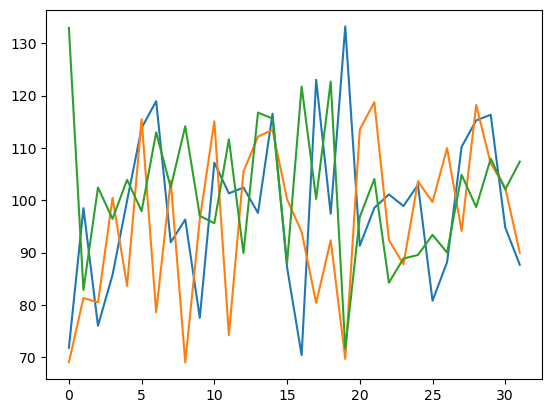

In [473]:
import matplotlib.pyplot as plt

plt.plot(I[0,0,:])
plt.plot(I[0,1,:])
plt.plot(I[0,2,:])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

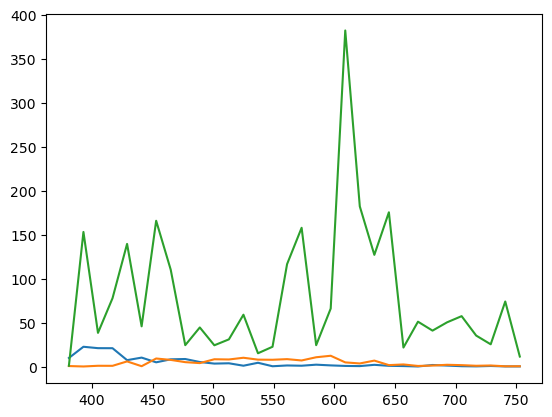

In [474]:
X = np.array(range(381,754,12))
plt.plot(X,I[-1,0,:])
plt.plot(X,I[-1,1,:])
plt.plot(X,I[-1,2,:])
plt.show

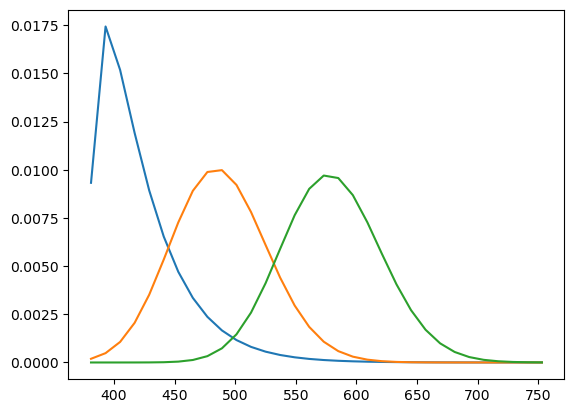

In [339]:
import numpy as np
import scipy.stats as sc

X = np.array(range(381,754,12))
plt.plot(X,sc.gamma.pdf(X-380,1.4,scale=30))
#plt.plot(X,sc.gamma.pdf(X,55,scale=10))
#plt.plot(X,sc.gamma.pdf(X,420,scale=1.6))
plt.plot(X,sc.gamma.pdf(X,150,scale=3.25))
plt.plot(X,sc.gamma.pdf(X,200,scale=2.9))
plt.show()

[0.44504103 0.5535908  0.00136816]
1.0
[0.61995389 0.02140419 0.35864192]
1.0
[0.14148362 0.68228963 0.17622675]
0.9999999999999999
[0.80702796 0.0015968  0.19137525]
1.0
[9.98004549e-01 1.36636140e-03 6.29089760e-04]
1.0


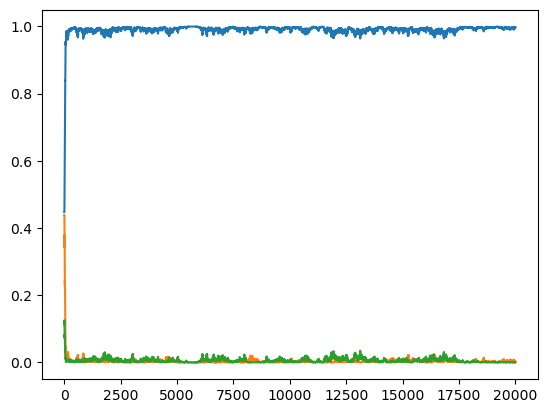

In [453]:
import numpy as np
import scipy.stats as sc
import matplotlib.pyplot as plt

for ii in range(0, NPix):
    print(Pi[-1,:,ii])
    print(np.sum(Pi[-1,:,ii]))

plt.plot(Pi[:,:,4])
plt.show()


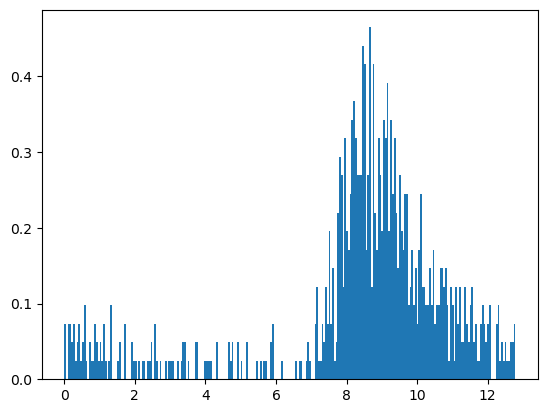

In [110]:
import matplotlib.pyplot as plt

plt.hist(Dt[0],bins= 256,density=True)
plt.show()

In [71]:
import numpy as np
import scipy as sc

#A = sc.dirichlet.pdf([0.2, 0.2, 0.2, 0.4])
B = np.random.dirichlet((0, 1, 2, 3),size=1000)



ValueError: alpha <= 0

In [281]:
import numpy as np

A = np.ones((1 , 10))
A - 2
np.random.gamma(1,10,[5,2])
np.divide(1,[2, 3, 0.5])


array([0.5       , 0.33333333, 2.        ])

In [469]:
import math

math.sqrt(2)
np.sqrt(2)
np.shape(Lambda)[0]



7